In [ ]:
# Swin Transformer V2 implementation reused from
# https://github.com/leondgarse/keras_cv_attention_models/blob/main/keras_cv_attention_models/resnet_family/resnet_deep.py
# - data preprocessing and brief EDA inspired by https://www.kaggle.com/code/tiletisaitejareddy/malware-classification-ism

In [1]:
# Dependencies
import sys
import os
from math import log
import numpy as np
import pandas as pd
import scipy as sp
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

2025-04-19 15:41:26.874160: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-19 15:41:26.934772: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-19 15:41:27.956303: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Data Preprocessing and Basic EDA

In [2]:
# prepare the data

train_root_path = "./malimg_dataset/train"
val_root_path = "./malimg_dataset/validation"

from tensorflow.keras.preprocessing.image import ImageDataGenerator
batches = ImageDataGenerator().flow_from_directory(directory=train_root_path, target_size=(64,64), batch_size=10000)

Found 6527 images belonging to 25 classes.


In [3]:
batches.class_indices

{'Adialer.C': 0,
 'Agent.FYI': 1,
 'Allaple.A': 2,
 'Allaple.L': 3,
 'Alueron.gen!J': 4,
 'Autorun.K': 5,
 'C2LOP.P': 6,
 'C2LOP.gen!g': 7,
 'Dialplatform.B': 8,
 'Dontovo.A': 9,
 'Fakerean': 10,
 'Instantaccess': 11,
 'Lolyda.AA1': 12,
 'Lolyda.AA2': 13,
 'Lolyda.AA3': 14,
 'Lolyda.AT': 15,
 'Malex.gen!J': 16,
 'Obfuscator.AD': 17,
 'Rbot!gen': 18,
 'Skintrim.N': 19,
 'Swizzor.gen!E': 20,
 'Swizzor.gen!I': 21,
 'VB.AT': 22,
 'Wintrim.BX': 23,
 'Yuner.A': 24}

In [4]:
imgs, labels = next(batches)
imgs.shape

(6527, 64, 64, 3)

In [5]:
labels.shape

(6527, 25)

In [6]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(batches.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

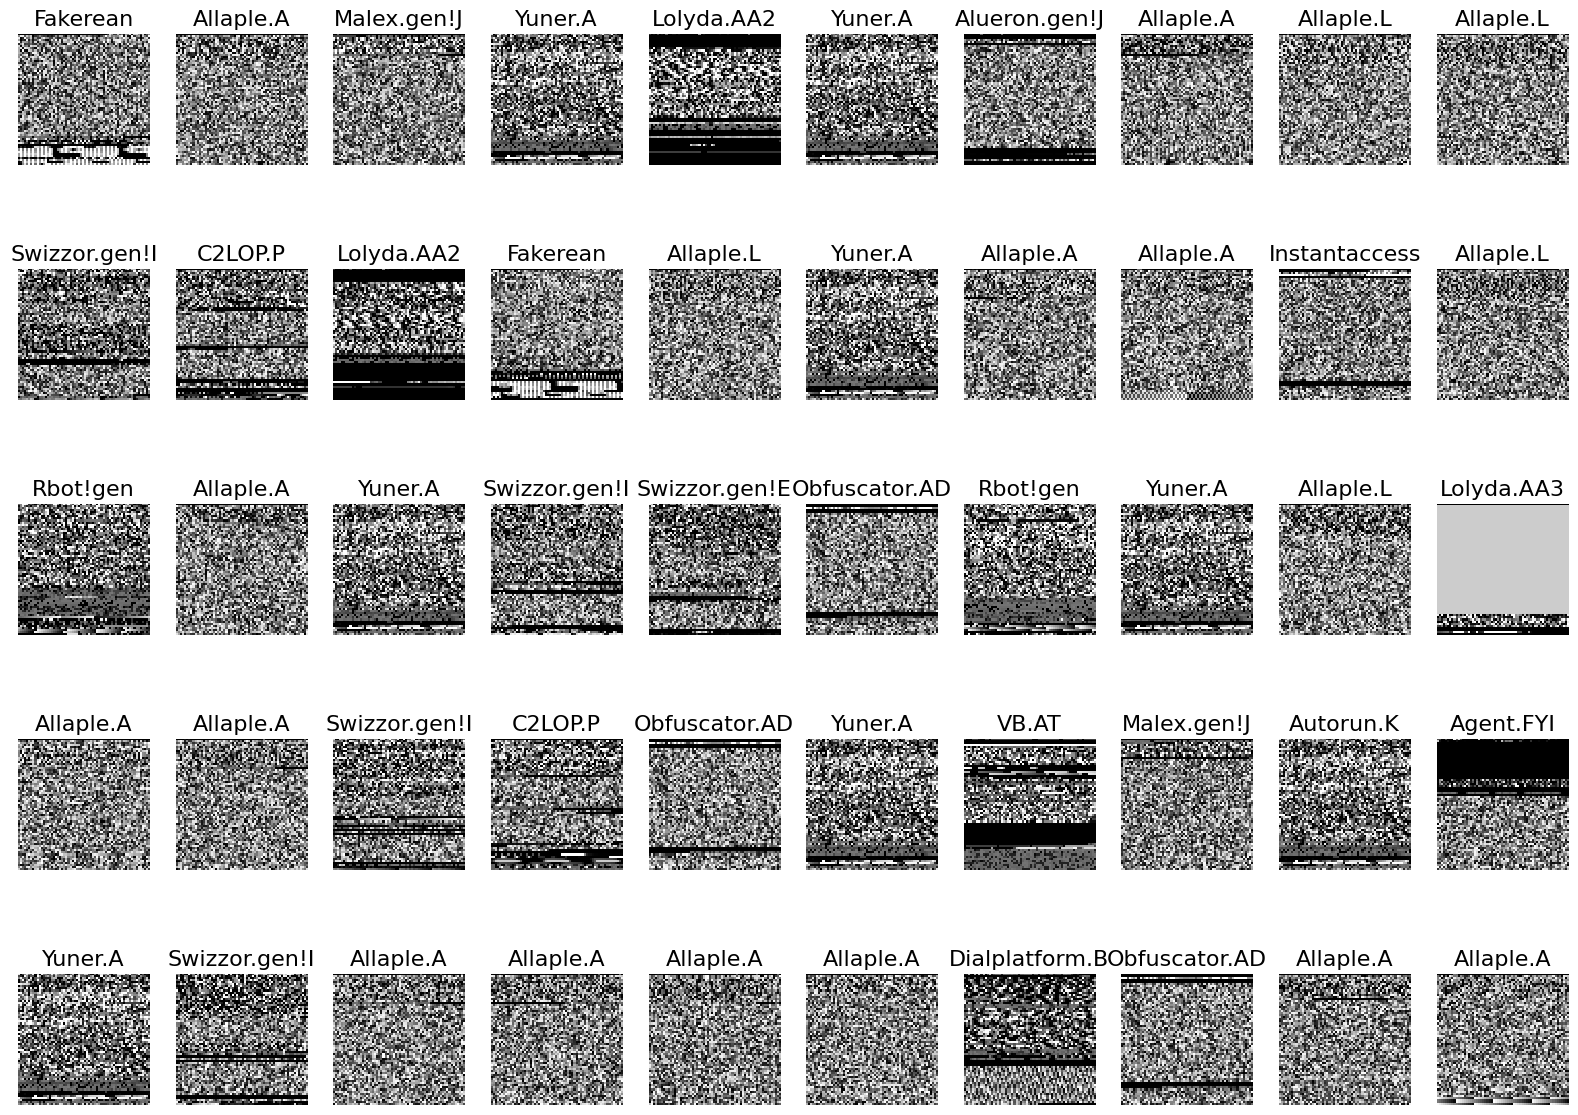

In [7]:
plots(imgs, titles = labels)

<BarContainer object of 25 artists>

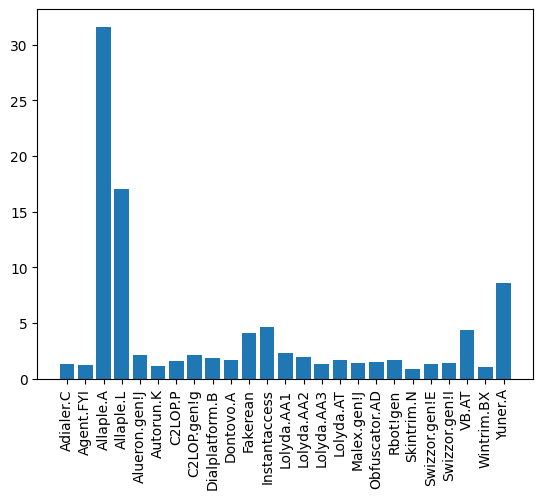

In [8]:
classes = batches.class_indices.keys()
perc = (sum(labels)/labels.shape[0])*100

plt.xticks(rotation='vertical')
plt.bar(classes,perc)

In [9]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(imgs/255.,labels, test_size=0.3)

In [10]:
x_train.shape

(4568, 64, 64, 3)

In [11]:
y_test.shape

(1959, 25)

In [12]:
num_classes = len(classes)
# we do not need to apply one-hot encoding to the labels as in https://keras.io/examples/vision/swin_transformers/
# since the dataset data is already prepared for the multi-class classification
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (4568, 64, 64, 3) - y_train shape: (4568, 25)
x_test shape: (1959, 64, 64, 3) - y_test shape: (1959, 25)


# ResNet Model

In [13]:
# Dependency from: https://github.com/qubvel/classification_models
from classification_models.tfkeras import Classifiers

def get_model(model_name, input_shape=(64, 64, 3), num_classes=25, pretrained=False):
    """
    Load a model from the classification_models library.

    Parameters:
        model_name (str): One of 'resnet18', 'resnet34', 'resnet50', 'resnet101',
                          'densenet121', 'densenet161', 'densenet169', 'densenet201'.
        input_shape (tuple): Image input size, default is (64, 64, 3).
        num_classes (int): Number of output classes.
        pretrained (bool): Whether to load ImageNet pretrained weights.

    Returns:
        model (tf.keras.Model): The compiled Keras model.
        preprocess_input (function): The preprocessing function for that model.
    """
    # Get the model and its preprocessing function
    ModelClass, preprocess_input = Classifiers.get(model_name.lower())

    # Load the model
    weights = 'imagenet' if pretrained else None
    model = ModelClass(input_shape=input_shape, weights=weights, classes=num_classes)

    return model, preprocess_input

In [14]:
model, preprocess_input = get_model(
    model_name='resnet18',
    input_shape=(64, 64, 3),
    num_classes=25,
    pretrained=False  # or True if doing transfer learning
)

model.summary()

2025-04-19 15:42:37.746101: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-19 15:42:37.927226: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, 64, 64, 3)            9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 70, 70, 3)            0         ['bn_data[0][0]']             
 g2D)                                                                                             
                                                                                              

In [13]:
from keras_cv_attention_models import resnet_family

# Configuration
input_shape = (64, 64, 3)
num_epochs = 40

batch_size = 128

learning_rate = 1e-3

validation_split = 0.1
weight_decay = 0.0001
label_smoothing = 0.1

# Load ResNet18 model
model = resnet_family.ResNet18(
    input_shape=input_shape,
    num_classes=num_classes,
    activation="relu",
    classifier_activation="softmax",
    pretrained="imagenet"  # or None if you want to train from scratch
)

AttributeError: module 'keras_cv_attention_models.resnet_family' has no attribute 'ResNet18'

In [15]:
import tensorflow_addons as tfa
model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

# model.summary()

In [16]:
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy',patience=4, verbose=1,  factor=0.4, min_lr=0.0001)

early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0.00001, patience=8, mode='auto', restore_best_weights=True)

model_fit = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=validation_split,
    verbose =1,
    callbacks=[early_stop,lr_reduction]
)

Epoch 1/40
42/42 [==============================] - 218s 5s/step - loss: 1.3799 - accuracy: 0.7385 - top-5-accuracy: 0.9214 - val_loss: 1.3795 - val_accuracy: 0.7963 - val_top-5-accuracy: 0.9745 - lr: 0.0010
Epoch 2/40
42/42 [==============================] - 213s 5s/step - loss: 0.7467 - accuracy: 0.9601 - top-5-accuracy: 0.9985 - val_loss: 0.7445 - val_accuracy: 0.9559 - val_top-5-accuracy: 0.9983 - lr: 0.0010
Epoch 3/40
42/42 [==============================] - 218s 5s/step - loss: 0.6620 - accuracy: 0.9924 - top-5-accuracy: 1.0000 - val_loss: 0.7367 - val_accuracy: 0.9610 - val_top-5-accuracy: 0.9949 - lr: 0.0010
Epoch 4/40
42/42 [==============================] - 212s 5s/step - loss: 0.6436 - accuracy: 0.9964 - top-5-accuracy: 1.0000 - val_loss: 0.7255 - val_accuracy: 0.9677 - val_top-5-accuracy: 0.9966 - lr: 0.0010
Epoch 5/40
42/42 [==============================] - 214s 5s/step - loss: 0.6377 - accuracy: 0.9979 - top-5-accuracy: 1.0000 - val_loss: 0.7273 - val_accuracy: 0.9542 - 

In [17]:
model.evaluate(x_test,  y_test)

79/79 [==============================] - 12s 153ms/step - loss: 0.7117 - accuracy: 0.9679 - top-5-accuracy: 0.9980


[0.7116930484771729, 0.9678826332092285, 0.998017430305481]

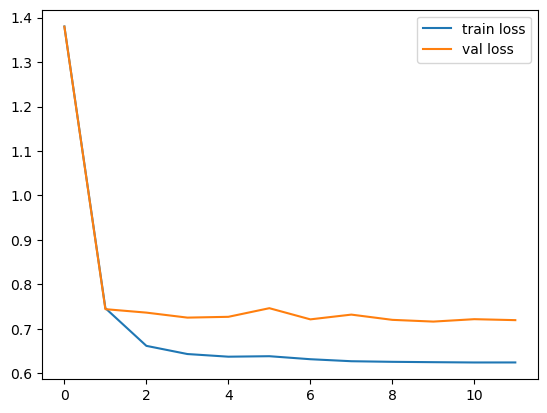

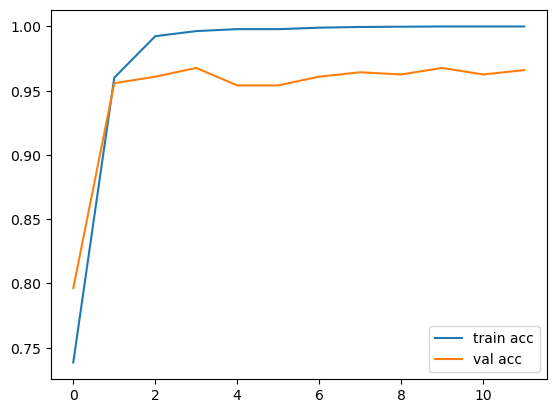

In [18]:
# plot the loss
plt.plot(model_fit.history['loss'], label='train loss')
plt.plot(model_fit.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('Swin_LossVal_loss.jpg',format='jpg')

plt.close()
# plot the accuracy
plt.plot(model_fit.history['accuracy'], label='train acc')
plt.plot(model_fit.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('Swin_AccVal_acc.jpg',format="jpg")

plt.close()

# Make predictions

In [19]:
pred_x = model.predict(x_test, verbose=0) 
y_pred=np.argmax(pred_x,axis=1)
y_pred

array([11,  6, 16, ...,  2, 22,  2], dtype=int64)

In [20]:
y_test2 = np.argmax(y_test, axis=1)
y_test2

array([11,  6, 16, ...,  2, 22,  2], dtype=int64)

In [21]:
from sklearn import metrics
c_matrix = metrics.confusion_matrix(y_test2, y_pred)

In [22]:
import seaborn as sns
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

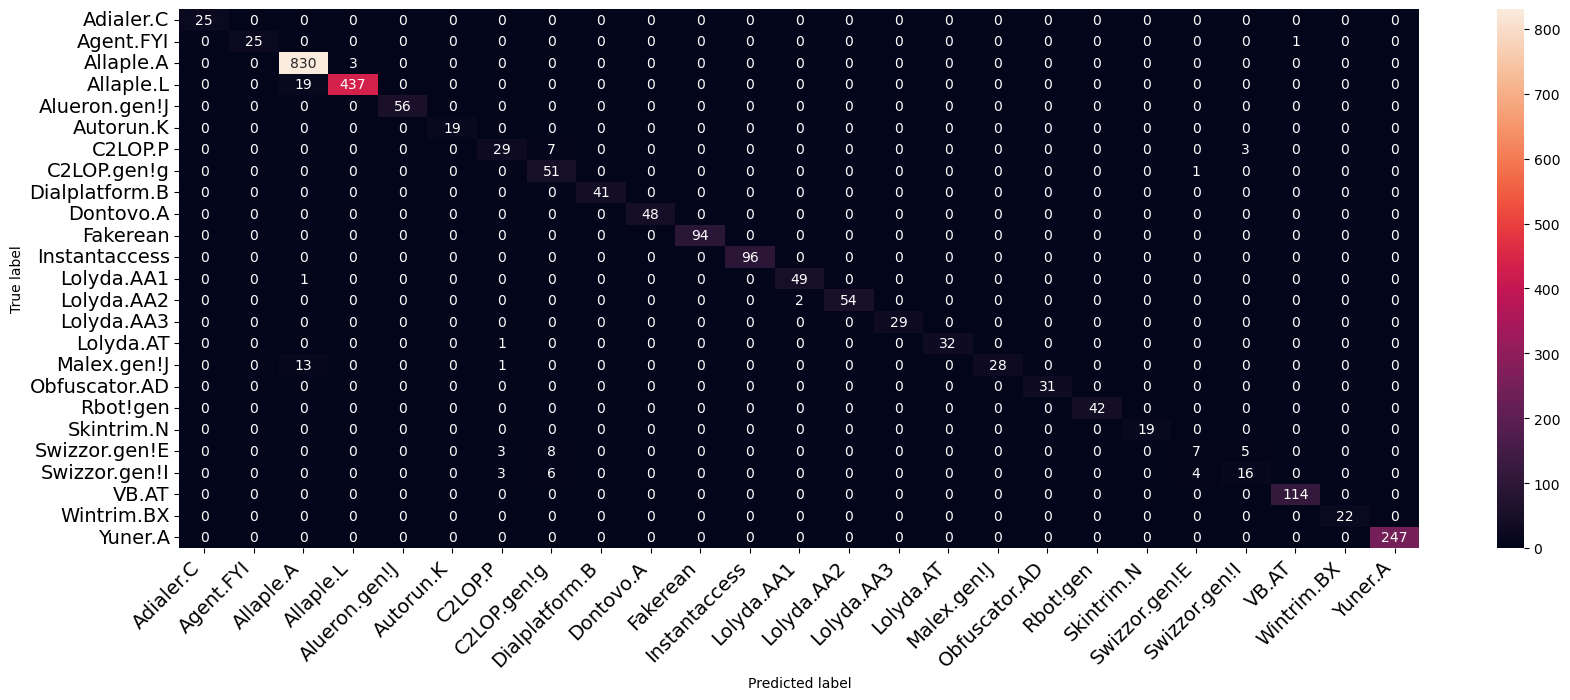

In [23]:
class_names= batches.class_indices.keys()
confusion_matrix(c_matrix, class_names, figsize = (20,7), fontsize=14)

In [24]:
from sklearn import metrics
# Print the precision and recall, among other metrics
report =  metrics.classification_report(y_test2, y_pred, digits=3, output_dict=True)

df = pd.DataFrame(report).transpose().reset_index()
df = df.rename(columns={"index": "class_label"})


Let's review the part of the classification report related to each individual class

In [25]:
clf_rep = metrics.precision_recall_fscore_support(y_test2, y_pred)
out_dict = {
             "precision" : clf_rep[0].round(3)
            ,"recall" : clf_rep[1].round(3)
            ,"f1-score" : clf_rep[2].round(3)
            ,"support" : clf_rep[3]
            }
out_df = pd.DataFrame(out_dict).reset_index().rename(columns={"index": "class_label"})
class_label_values = dict(zip(range(0,len(batches.class_indices)), batches.class_indices))
out_df['class_label'] = out_df['class_label'].map(class_label_values)
out_df

,class_label,precision,recall,f1-score,support
0,Adialer.C,1.000,1.000,1.000,25
1,Agent.FYI,1.000,0.962,0.980,26
2,Allaple.A,0.962,0.996,0.979,833
3,Allaple.L,0.993,0.958,0.975,456
4,Alueron.gen!J,1.000,1.000,1.000,56
5,Autorun.K,1.000,1.000,1.000,19
6,C2LOP.P,0.784,0.744,0.763,39
7,C2LOP.gen!g,0.708,0.981,0.823,52
8,Dialplatform.B,1.000,1.000,1.000,41
9,Dontovo.A,1.000,1.000,1.000,48


Now let's review the aggregated values from  the classification report

In [26]:
# display aggregated values - selecting rows based on condition 
options = ['accuracy', 'macro avg',  'weighted avg']
agg_df = df[df['class_label'].isin(options)]
agg_df

,class_label,precision,recall,f1-score,support
25,accuracy,0.967883,0.967883,0.967883,0.967883
26,macro avg,0.945966,0.923094,0.930260,2522.000000
27,weighted avg,0.967977,0.967883,0.966277,2522.000000
